In [ ]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pickle
from sklearn.metrics import classification_report
from sklearn.datasets import make_circles, make_moons
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
!tar -xvzf cifar-100-python.tar.gz

--2022-10-27 13:41:12--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  96.2MB/s    in 1.7s    

2022-10-27 13:41:15 (96.2 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


In [ ]:
# Чтение тренировочной выборки (обучающих данных)
with open('cifar-100-python/train', 'rb') as f: #Режим открытия файла - read binary (rb)
    data_train = pickle.load(f, encoding='latin1')

# Чтение тестовой выборки (тестовых данных)
with open('cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

In [ ]:
CLASSES = [1, 13, 43]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCHW -> NHWC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test

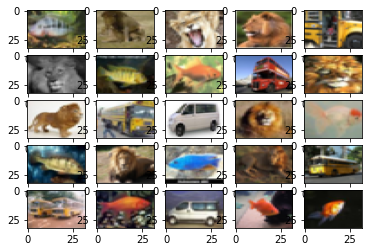

In [ ]:
fig, ax = plt.subplots(5, 5)
k = 0
 
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(train_X[k], aspect='auto')
        k += 1
 
plt.show()

In [ ]:
# Указываем размер батча 
batch_size = 128

dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader
dataloader


{'train': <torch.utils.data.dataloader.DataLoader at 0x7f1eac36dc10>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f1eaaf5fed0>}

In [ ]:
class Normalize(nn.Module):
    def __init__(self, mean, std): #std-стандартное отклонение
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return torch.flatten(x, start_dim=1) # nhwc -> nm

# Создадим простой многослойный перцептрон с одним скрытым слоем и функцией нелинейности.
# Количество скрытых слоев можно изменять.
class Cifar100_MLP(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_MLP, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025])
        self.seq = nn.Sequential(
            nn.Linear(32*32*3, hidden_size), 
            nn.ReLU(), # активационная функция
            nn.Linear(hidden_size, classes),
        )

    def forward(self, input):
        x = self.norm(input)
        return self.seq(x)

HIDDEN_SIZE = 10
model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [ ]:
# Функция потерь
criterion = nn.CrossEntropyLoss()
# Оптимизатор
# lr - шаг обучения. Данный параметр можно изменять.
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [ ]:
# Укажем количество эпох. 
# Увеличение количества эпох приводит к увеличению времени работы программы.
# Чем больше эпох мы обучаем, тем точнее обучается модель, но есть риск наступления переобучения.

EPOCHS = 250
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    running_loss = 0.0
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch
        
        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()

        #Для обновления параметров нейронной сети используется метод step, применённый к экземпляру класса оптимизатора.
        optimizer.step()

        # для подсчёта статистик
        running_loss += loss.item()
    print(f'{epoch + 1} loss: {running_loss / steps_per_epoch:.3f}')
    running_loss = 0.0

    #Для перевода модели в состояние проверки необходимо вызвать метод eval. После чего модель готова для проверки.
    model.eval()

    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    print(f'{epoch + 1} val loss: {running_loss / steps_per_epoch_val:.3f}')
print('Обучение закончено')

1 loss: 1.046
1 val loss: 0.932
2 loss: 0.900
2 val loss: 0.805
3 loss: 0.821
3 val loss: 0.741
4 loss: 0.773
4 val loss: 0.736
5 loss: 0.738
5 val loss: 0.690
6 loss: 0.716
6 val loss: 0.679
7 loss: 0.695
7 val loss: 0.684
8 loss: 0.678
8 val loss: 0.668
9 loss: 0.664
9 val loss: 0.634
10 loss: 0.647
10 val loss: 0.624
11 loss: 0.640
11 val loss: 0.636
12 loss: 0.631
12 val loss: 0.603
13 loss: 0.620
13 val loss: 0.604
14 loss: 0.610
14 val loss: 0.617
15 loss: 0.600
15 val loss: 0.594
16 loss: 0.592
16 val loss: 0.629
17 loss: 0.586
17 val loss: 0.600
18 loss: 0.576
18 val loss: 0.575
19 loss: 0.569
19 val loss: 0.559
20 loss: 0.563
20 val loss: 0.545
21 loss: 0.554
21 val loss: 0.601
22 loss: 0.551
22 val loss: 0.573
23 loss: 0.541
23 val loss: 0.551
24 loss: 0.534
24 val loss: 0.592
25 loss: 0.527
25 val loss: 0.553
26 loss: 0.521
26 val loss: 0.530
27 loss: 0.515
27 val loss: 0.573
28 loss: 0.507
28 val loss: 0.565
29 loss: 0.505
29 val loss: 0.628
30 loss: 0.499
30 val loss: 0.57

In [ ]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data

            outputs = model(inputs).detach().numpy()
            #Выходной тензор предсказаний модели необходимо отсечь от вычислительного графа. 
            #Для этого используется метод detach, применённый к выходному тензору модели. 
            #В противном случае возможны утечки памяти. 
            #Метод numpy конвертирует тензор в многомерный массив NumPy.
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        
        # Выведем отчет о точности обучения модели.
        # Выведем метрики ранжирования для тестовой и обучающей выборки.
        print(part)

        # Значения выводятся с точность 4 знака после запятой.

        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)
        #– Точность (Precision) – Процент положительных меток, которые правильно определены
        #Precision = (# true positives) / (# true positives + # false positives)
        #– Полнота (Recall) – Процент положительных примеров, которые были правильно определены
        #Recall = (# true positives) / (# true positives + # false negatives)
        #– Accuracy – Процент положительных меток
        #Accuracy = (# true positives + # true negatives) / (# of samples)
        #support - количество значений, принадлежащих данному классу

train
              precision    recall  f1-score   support

           1     0.9940    0.9880    0.9910       500
          13     0.9960    0.9920    0.9940       500
          43     0.9861    0.9960    0.9910       500

    accuracy                         0.9920      1500
   macro avg     0.9920    0.9920    0.9920      1500
weighted avg     0.9920    0.9920    0.9920      1500

--------------------------------------------------
test
              precision    recall  f1-score   support

           1     0.7500    0.8400    0.7925       100
          13     0.8750    0.8400    0.8571       100
          43     0.8152    0.7500    0.7813       100

    accuracy                         0.8100       300
   macro avg     0.8134    0.8100    0.8103       300
weighted avg     0.8134    0.8100    0.8103       300

--------------------------------------------------


In [ ]:
# сохранение всей архитектуры
PATH2 = 'cifar_lnn.pt'
torch.save(model, PATH2)
# загрузка
new_model_2 = torch.load(PATH2)
new_model_2.eval() #Для перевода модели в состояние проверки необходимо вызвать метод eval. После чего модель готова для проверки.

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [ ]:
# входной тензор для модели
x = torch.randn(1, 32, 32, 3, requires_grad=True).to('cpu')
torch_out = model(x)

# экспорт модели
torch.onnx.export(model,               # модель
                  x,                   # входной тензор (или кортеж нескольких тензоров)
                  "cifar100_LNN.onnx", # куда сохранить (либо путь к файлу либо fileObject)
                  export_params=True,  # сохраняет веса обученных параметров внутри файла модели
                  opset_version=9,     # версия ONNX
                  do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
                  input_names = ['input'],   # имя входного слоя
                  output_names = ['output'],  # имя выходного слоя
                  dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
                                'output' : {0 : 'batch_size'}})